# Computing Price and Promo elasticities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px

# Create the dataset

The dataset should have values for each day for at least 2 years. The promotions generally run during the months of Feb, March and then Nov, Dec. The promotions are generally offered as a percent of the price off. For example, 15% off the price of $3.99

## Class and methods for generating the dataframe

In [2]:
class Generate_Dataset:

    """
    Class for generating and visualizing dataset
    Takes the following arguments to initialize

    Parameters
    -------------
    start_date : datetime
        start date for the dataset
    end_date : datetime
        end date of the dataset
    stores : dict
        A dictionary containing the store names as keys and their unit sold intercepts as values
    """

    def __init__(self, start_date:str, end_date:str, stores:dict = None) -> None:
        self.start_date = start_date
        self.end_date = end_date
        self.store_weights = stores
        self.date_array = pd.date_range(start=start_date, end=end_date, freq='D')
        

    def generate_df(self, wt_price:float, wt_promo:float):
        """
        Function to generate the dataframe

        Parameters
        -------------
        start_date : datetime
            start date for the dataset
        end_date : datetime
            end date of the dataset
        stores : dict
            A dictionary containing the store names as keys and their unit sold intercepts as values

        Values
        -------------
        returns a dataframe with the columns date, price, promo_amount, units_sold.
        """

        ## Price
        price = np.where(self.date_array.month<=6, 3, 6) #* np.random.normal(loc = 1, scale = 0.05, size = self.date_array.shape[0])

        # Promo indicator and promo
        promo_indicator = np.isin(self.date_array.month, [2,3,11,12])
        promo_amount = np.where(self.date_array.month <=6, 0.2*price, 0.3*price)

        ## Total units sold
        #np.zeros(shape = self.date_array.shape, dtype=np.float32)
        total_units_sold = 2 + (wt_price * np.power(price, 2)) + wt_promo * np.log(1+promo_amount) * promo_indicator + np.random.normal(loc= 0, scale = 0.1, size = self.date_array.shape[0])
        # total_units_sold = np.max(np.array([total_units_sold, np.zeros(shape = self.date_array.shape)]), axis = 0)  ## Make sure that the untis sold is never negative
        total_units_sold = np.exp(total_units_sold) #Makes sure that the units are positive

        pdf_ = pd.DataFrame({"date":self.date_array,
                            "price":price,
                            "promo_amount":promo_amount * promo_indicator,
                            "units_sold":total_units_sold})

        self.data = pdf_

        return self.data

    def viz_ts_data(self):
        """
        Visualizes the generated data
        """
        df_melted = self.data.melt(id_vars="date")

        fig = px.line(data_frame=df_melted, x = 'date', y = 'value', color='variable')
        fig.show()  


In [3]:
SALES = Generate_Dataset(start_date="2021-01-01", end_date="2021-12-31")

In [4]:
weights = {"wt_price":-0.008, "wt_promo":0.3}
df_sales = SALES.generate_df(**weights)

In [5]:
df_sales.head()

,date,price,promo_amount,units_sold
0,2021-01-01,3,0.0,7.020426
1,2021-01-02,3,0.0,7.817346
2,2021-01-03,3,0.0,7.154421
3,2021-01-04,3,0.0,6.444740
4,2021-01-05,3,0.0,8.252019


In [6]:
SALES.viz_ts_data()

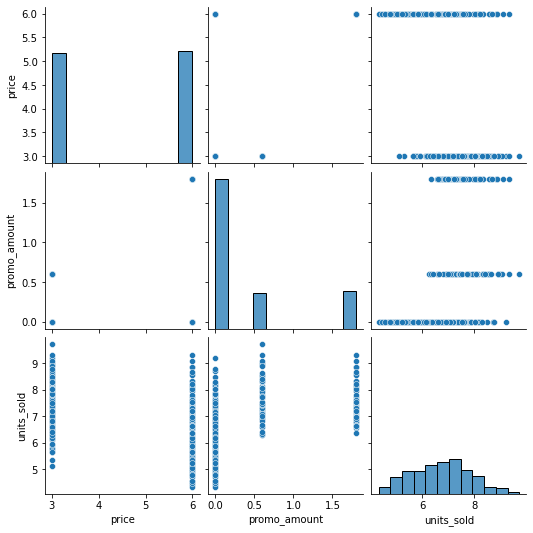

In [7]:
sns.pairplot(data = df_sales)

# Models to estimate the causal effect of promo and prices on units sold

In [8]:
df_sales.dtypes

date            datetime64[ns]
price                    int32
promo_amount           float64
units_sold             float64
dtype: object

In [79]:
def plot_predictions(model, dataset, y = 'units_sold', output_transform = True):
    
    """
    Parameters
    --------------
    model: statemodel
        A model whose predict function would be called on the dataset
    dataset: pd.DataFrame
        A dataset on which the model's predict method would be called
    
    Values
    --------------
    plots a plotly plot for comparing the prediction and the actual
    """
    if output_transform:
        df_predicted = (dataset
        .assign(predicted = np.exp(model.predict(dataset)))
        .loc[:, ['date', y, 'predicted']]
        .melt(id_vars = 'date')
        )

    fig1 =  px.line(data_frame = df_predicted, x = 'date', y = 'value', color = 'variable')

    fig1.show()

## Simple model

A model without the correct specification of the transformations

In [10]:
model1 = smf.ols("units_sold ~ price + promo_amount", data = df_sales).fit()

In [11]:
print(f"model estimates : \n{model1.params[-2:]}")
print(f"original_estimates = {weights}")

model estimates : 
price          -0.475156
promo_amount    1.141561
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


**Estimates are way off**

In [12]:
plot_predictions(model1, df_sales)

## Model with exact functional form

This should be able to recover the exact estimates. However, in practicality, this cannot be implemented as we would never know the exact form.

In [41]:
df_sales = (df_sales
    .assign(log_one_plus_promo = lambda df: np.log(1+df.promo_amount))
    .assign(squared_price = lambda df: np.power(df.price, 2))
)

In [72]:
model2 = smf.ols("np.log(units_sold) ~ np.power(price, 2) + np.log(promo_amount + 1)", data = df_sales).fit()

In [73]:
print(f"model estimates : \n{model2.params[-2:]}")
print(f"original_estimates = {weights}")

model estimates : 
np.power(price, 2)         -0.007717
np.log(promo_amount + 1)    0.290078
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


In [80]:
plot_predictions(model2, df_sales, output_transform=True)

**This recovers the correct estimates**

<AxesSubplot:ylabel='Density'>

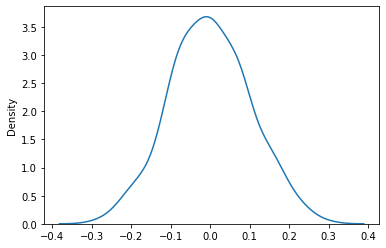

In [81]:
## Residuals analysis
sns.kdeplot(model2.resid)

In [46]:
np.max(model2.resid)

9.707596509669948

**Residuals seem really bad, but..**

Note that the values are extremely small (in range of 1e-15). Even though the residuals are not normally distributed, they are almost non-existent. So, this should not be concerning.

## Model with interaction between promo_indicator and promo_amount

In [82]:
df_sales = (df_sales
    .assign(promo_ind = lambda df: np.where(df.promo_amount==0, 0, 1))
    .assign(log_promo = lambda df: np.log(df.promo_amount+ 0.00001))
    .assign(log_three_plus_promo = lambda df: np.log(3+df.promo_amount))
    .assign(log_sales_units = lambda df: np.log(df.units_sold))
)
df_sales.head()

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
0,2021-01-01,3,0.0,7.020426,0.0,9,0,-11.512925,1.098612,1.948824
1,2021-01-02,3,0.0,7.817346,0.0,9,0,-11.512925,1.098612,2.056345
2,2021-01-03,3,0.0,7.154421,0.0,9,0,-11.512925,1.098612,1.967730
3,2021-01-04,3,0.0,6.444740,0.0,9,0,-11.512925,1.098612,1.863264
4,2021-01-05,3,0.0,8.252019,0.0,9,0,-11.512925,1.098612,2.110458


In [104]:
model3 = smf.ols("np.log(units_sold) ~ price + squared_price + log_promo * promo_amount", data = df_sales).fit()

In [105]:
print(f"model estimates : \n{model3.params}")
print(f"original_estimates = {weights}")

model estimates : 
Intercept                 0.388066
price                     0.765763
squared_price            -0.093321
log_promo                -0.007669
promo_amount              0.274984
log_promo:promo_amount   -0.085390
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


In [106]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(units_sold)   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     209.4
Date:                Sun, 07 May 2023   Prob (F-statistic):           1.15e-78
Time:                        17:54:41   Log-Likelihood:                 316.20
No. Observations:                 365   AIC:                            -624.4
Df Residuals:                     361   BIC:                            -608.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.3881      0.003    136.314      0.000       0.382       0.394
price                      0.7658      0.006    136.402      0.000       0.755       0.777
squared_price             -0.0933      0.001   -108.670      0.000      -0.095      -0.092
log_promo                 -0.0077      0.002     -5.051      0.000      -0.011      -0.005
promo_amount               0.2750      0.008     35.774      0.000       0.260       0.290
log_promo:promo_amount    -0.0854      0.011     -7.725      0.000      -0.107      -0.064
==============================================================================
Omnibus:                        0.662   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.779
Skew:                           0.075   Prob(JB):                        0.677
Kurtosis:                       2.830   Cond. No.                     1.01e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.74e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<AxesSubplot:xlabel='log_promo', ylabel='Count'>

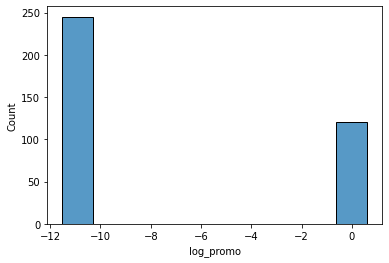

In [107]:
sns.histplot(df_sales, x = "log_promo")

In [108]:
plot_predictions(model3, df_sales, y = 'units_sold')

<AxesSubplot:ylabel='Density'>

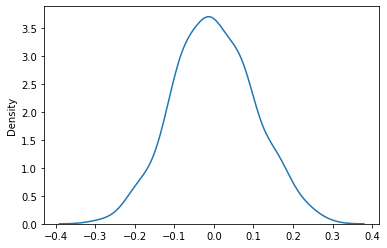

In [109]:
sns.kdeplot(model3.resid)

**Comment :**  
This model also approximates the original functional form almost exactly. The residuals are more normally distributed, but, again are extremely small - suggesting that we are doing a good job. The key take away is, we haven't specified the exact functional form in this model and yet were able to get almost spot-on predictions. The challenge here is to see how good our coefficients from non-linearities are as an approximation to the original functional form.

## Test changes in promo prices

In [110]:
df_sales.iloc[30:40, :]

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
30,2021-01-31,3,0.0,5.750959,0.000000,9,0,-11.512925,1.098612,1.749367
31,2021-02-01,3,0.6,6.287101,0.470004,9,1,-0.510809,1.280934,1.838500
32,2021-02-02,3,0.6,7.264622,0.470004,9,1,-0.510809,1.280934,1.983016
33,2021-02-03,3,0.6,8.127901,0.470004,9,1,-0.510809,1.280934,2.095303
34,2021-02-04,3,0.6,7.682607,0.470004,9,1,-0.510809,1.280934,2.038959
35,2021-02-05,3,0.6,8.980690,0.470004,9,1,-0.510809,1.280934,2.195077
36,2021-02-06,3,0.6,7.319672,0.470004,9,1,-0.510809,1.280934,1.990566
37,2021-02-07,3,0.6,8.989481,0.470004,9,1,-0.510809,1.280934,2.196055
38,2021-02-08,3,0.6,8.519506,0.470004,9,1,-0.510809,1.280934,2.142358
39,2021-02-09,3,0.6,6.590039,0.470004,9,1,-0.510809,1.280934,1.885559


In [111]:
0.64/3.22

0.19875776397515527

In [112]:
def gen_simulated_df(price:float, model, feature_gen:bool = True):
    
    df_simulated = pd.DataFrame({"price":price,
                            "promo_amount": np.concatenate([np.repeat(0.0, 33), np.repeat(0.2*price, 33), np.repeat(0.3*price, 33)])})

    # df_simulated = pd.DataFrame({"price": price,
    #                             "promo_amount":np.linspace(0, 0.3, 100)})

    df_simulated = df_simulated.assign(promo_ind = lambda df: np.where(df.promo_amount==0, 0, 1))

    if feature_gen:
        df_simulated = (df_simulated
            .assign(log_promo = lambda df: np.log(df.promo_amount+0.00001))
            .assign(squared_price = lambda df: np.power(df.price, 2))
            .assign(log_one_plus_promo = lambda df: np.log(1 + df.promo_amount))
        )

    wt_price = -0.008
    wt_promo = 0.3


    df_simulated = (df_simulated
    .assign(predicted_units = model.predict(df_simulated))
    .assign(actual_units = lambda df: 2 + (wt_price * np.power(df.price, 2)) + wt_promo * np.log(1+df.promo_amount))
    )

    return df_simulated

In [113]:
df_simPrice3 = gen_simulated_df(price = 3.0, model = model3)
df_simPrice6 = gen_simulated_df(price = 6.0, model = model3)

df_sim = pd.concat([df_simPrice3, df_simPrice6], axis = 0)
df_sim2 = df_sim.loc[:, ['price', 'promo_amount', 'predicted_units','actual_units']].melt(id_vars = ['price', 'promo_amount'])

In [114]:
px.line(data_frame = df_sim2, x = 'promo_amount', y = 'value', line_dash = 'variable', color = 'price')#, facet_row = 'price')

# Using a complex tree based model for this prediction

In [115]:
from sklearn.ensemble import GradientBoostingRegressor

In [116]:
df_sales.head()

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
0,2021-01-01,3,0.0,7.020426,0.0,9,0,-11.512925,1.098612,1.948824
1,2021-01-02,3,0.0,7.817346,0.0,9,0,-11.512925,1.098612,2.056345
2,2021-01-03,3,0.0,7.154421,0.0,9,0,-11.512925,1.098612,1.967730
3,2021-01-04,3,0.0,6.444740,0.0,9,0,-11.512925,1.098612,1.863264
4,2021-01-05,3,0.0,8.252019,0.0,9,0,-11.512925,1.098612,2.110458


In [117]:
X = df_sales.loc[:, ['price','promo_amount', 'promo_ind']]#, 'log_promo', 'squared_price', 'log_one_plus_promo']]
y = df_sales.units_sold

In [118]:
model4 = GradientBoostingRegressor().fit(X, y)

In [119]:
df_model4_sim3 = gen_simulated_df(price = 3.0, model = model4, feature_gen = False)
df_model4_sim6 = gen_simulated_df(price = 6.0, model = model4, feature_gen = False)

In [120]:
df_sim4 = pd.concat([df_model4_sim3, df_model4_sim6], axis = 0)
df_sim42 = df_sim4.loc[:, ['price', 'promo_amount', 'predicted_units','actual_units']].melt(id_vars = ['price', 'promo_amount'])

In [121]:
px.line(data_frame = df_sim42, x = 'promo_amount', y = 'value', line_dash = 'variable', color = 'price')#, facet_row = 'price')

In [122]:
df_predicted0 = (df_sales
    .assign(predicted = model4.predict(df_sales.loc[:,  ['price','promo_amount', 'promo_ind',]]))# 'log_promo', 'squared_price', 'log_one_plus_promo']]))
    .loc[:, ['date', 'units_sold', 'predicted']]
)

# pred_df = df_sales

fig1 =  px.line(data_frame = df_predicted0.melt(id_vars = 'date'), x = 'date', y = 'value', color = 'variable')

fig1.show()

<AxesSubplot:xlabel='residuals', ylabel='Density'>

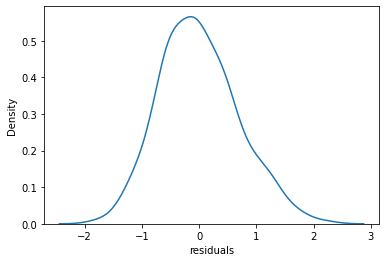

In [123]:
sns.kdeplot(x='residuals', data = df_predicted0.assign(residuals = lambda df: df.units_sold - df.predicted))

In [124]:
model4.feature_importances_

array([0.42598123, 0.32537791, 0.24864087])

# DoubleML Cate estimates

In [125]:
df_sales

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
0,2021-01-01,3,0.0,7.020426,0.000000,9,0,-11.512925,1.098612,1.948824
1,2021-01-02,3,0.0,7.817346,0.000000,9,0,-11.512925,1.098612,2.056345
2,2021-01-03,3,0.0,7.154421,0.000000,9,0,-11.512925,1.098612,1.967730
3,2021-01-04,3,0.0,6.444740,0.000000,9,0,-11.512925,1.098612,1.863264
4,2021-01-05,3,0.0,8.252019,0.000000,9,0,-11.512925,1.098612,2.110458
...,...,...,...,...,...,...,...,...,...,...
360,2021-12-27,6,1.8,7.302131,1.029619,36,1,0.587792,1.568616,1.988166
361,2021-12-28,6,1.8,6.977204,1.029619,36,1,0.587792,1.568616,1.942648
362,2021-12-29,6,1.8,7.213772,1.029619,36,1,0.587792,1.568616,1.975992
363,2021-12-30,6,1.8,6.648815,1.029619,36,1,0.587792,1.568616,1.894439


In [127]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict, train_test_split

In [128]:
X = ["price"]
T = "promo_amount"
y = "units_sold"
debias_m = LGBMRegressor()
denoise_m = LGBMRegressor()
t_res =  df_sales[T] - cross_val_predict(debias_m, df_sales[X], df_sales[T], cv=5)
y_res =  df_sales[y] - cross_val_predict(denoise_m, df_sales[X], df_sales[y], cv=5)

In [129]:
import statsmodels.api as sm

sm.OLS(y_res, t_res).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
promo_amount,1.1482,0.039,29.271,0.000,1.071,1.225


## CATE estimates

In [131]:
y_star = y_res/t_res
w = t_res**2
cate_model = LGBMRegressor().fit(df_sales[X], y_star, sample_weight=w)
test_r_learner_pred = df_sales.assign(cate = cate_model.predict(df_sales[X]))

In [132]:
test_r_learner_pred

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units,cate
0,2021-01-01,3,0.0,7.020426,0.000000,9,0,-11.512925,1.098612,1.948824,1.380402
1,2021-01-02,3,0.0,7.817346,0.000000,9,0,-11.512925,1.098612,2.056345,1.380402
2,2021-01-03,3,0.0,7.154421,0.000000,9,0,-11.512925,1.098612,1.967730,1.380402
3,2021-01-04,3,0.0,6.444740,0.000000,9,0,-11.512925,1.098612,1.863264,1.380402
4,2021-01-05,3,0.0,8.252019,0.000000,9,0,-11.512925,1.098612,2.110458,1.380402
...,...,...,...,...,...,...,...,...,...,...,...
360,2021-12-27,6,1.8,7.302131,1.029619,36,1,0.587792,1.568616,1.988166,1.133536
361,2021-12-28,6,1.8,6.977204,1.029619,36,1,0.587792,1.568616,1.942648,1.133536
362,2021-12-29,6,1.8,7.213772,1.029619,36,1,0.587792,1.568616,1.975992,1.133536
363,2021-12-30,6,1.8,6.648815,1.029619,36,1,0.587792,1.568616,1.894439,1.133536


In [139]:
price = 3.0

df_simulated = pd.DataFrame({"price":price,
                            "promo_amount": np.concatenate([np.repeat(0.0, 33), np.repeat(0.2*price, 33), np.repeat(0.3*price, 33)])})



In [144]:
df_CATE_predictions = df_simulated.assign(predicted = cate_model.predict(df_simulated.loc[:, ['price']]))

In [145]:
df_CATE_predictions

,price,promo_amount,predicted
0,3.0,0.0,1.380402
1,3.0,0.0,1.380402
2,3.0,0.0,1.380402
3,3.0,0.0,1.380402
4,3.0,0.0,1.380402
...,...,...,...
94,3.0,0.9,1.380402
95,3.0,0.9,1.380402
96,3.0,0.9,1.380402
97,3.0,0.9,1.380402


In [148]:
px.line(data_frame = df_CATE_predictions, x = 'promo_amount', y = 'predicted', color = 'price')#, facet_row = 'price')

In [149]:
np.exp(1.928)

6.875744990937191